<a href="https://colab.research.google.com/github/kcw0331/Deeplearning/blob/main/4_4_overfitting_and_underfitting(%EA%B9%80%EC%B0%BD%EC%9A%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Mar 30 02:58:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

# Overfitting and underfitting

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


In all the examples we saw in the previous chapter -- movie review sentiment prediction, topic classification, and house price regression -- 
we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start 
degrading, i.e. our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning 
problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get 
more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization 
techniques, and let's apply them in practice to improve our movie classification model from  the previous chapter.

- The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before.

- 여기는 overfitting과 underfitting에 대해서 소개하고 있다.
-  Training data를 통해서 최적화 시키는거랑 이벨류에잇 셋에서 제너럴라이제이션이 얼마나 잘 되는지he fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

Let's prepare the data using the code from Chapter 3, Section 5:

- 우리는 데이터를 사용해서 과적합이 어떠한 상황인지랑 레귤렐리제이션의 기법들이 어떤것들이 있는지에 대해 예제를 진행하신다고 말씀하심. 그리고 여기에서 사용하는 것은 Chapter3의 Section 5에 있는 imovie에 대한 데이터이다.

In [ ]:
#그래서 여기에서는 imdb에 대한 데이터를 불러오고 있다.
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets 
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

- overfitting과 싸우는 방법 중 하나가 network를 단순하게 만들어 주는 방법이 있다.

In [ ]:
#이 코드는 기존에 있던 모형에 대한 것이다.
from tensorflow.keras import models
from tensorflow.keras import layers

original_model = models.Sequential()  #Sequntial모델로 정의를 하고
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))  #Dense layers를 16짜리를 하나 달고,
original_model.add(layers.Dense(16, activation='relu'))  #그 다음 Dense layers를 16짜리를 하나 더 달고,
original_model.add(layers.Dense(1, activation='sigmoid')) #그리고 여기에서 sigmoid함수를 사용해서 Dense layers를 1개 달아 준 다음에

original_model.compile(optimizer='rmsprop',   #그리고 여기에서 컴파일을 해서 초기모형을 달았다.
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

# 사이즈를 작게 해주는 방법

In [ ]:
#위에서는 Dense layer를 16으로 잡았는데, 여기에서는 Dense layer를 4로 잡아서 단순화 시켰다.
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))  #여기에서는 위에서 16으로 했던것을 4로 단다음에
smaller_model.add(layers.Dense(4, activation='relu')) #그리고 여기에도 4로 달아주고
smaller_model.add(layers.Dense(1, activation='sigmoid')) #여기에서는 1로 달어줘서 이전의 코드보다 훨씬 작게 해주었다.

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [ ]:
#여기는 교수님이 학습을 하기전에 original_model에 대해서 summary를 본다고 하심.
original_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#그리고 smaller_model에 대해 summary를 해주심.
smaller_model.summary()

#그래서 여기에서 보면 Shape이 16에서 4로 줄어든 것을 볼 수 있다. 그리고 Trainable params가 160,305에서 40,029로 줄어든 것을 볼 수 있다.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________



Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [ ]:
#여기에서는 original model을 train시켜본다.
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,  #epochs은 20으로 하고 
                                   batch_size=512, #batch_size는 512로 해준다.
                                   validation_data=(x_test, y_test))
#그래서 코드를 돌려보면 train acc는 계속해서 숫자가 올라가는 것을 볼 수 있지만, val_acc는 어느 정도 올라가다가 정체되는 것을 볼 수 있다.

Epoch 1/20
49/49 [==============================] - 4s 67ms/step - loss: 0.5486 - acc: 0.7399 - val_loss: 0.3372 - val_acc: 0.8814
Epoch 2/20
49/49 [==============================] - 2s 43ms/step - loss: 0.2722 - acc: 0.9088 - val_loss: 0.3254 - val_acc: 0.8651
Epoch 3/20
49/49 [==============================] - 2s 43ms/step - loss: 0.2023 - acc: 0.9289 - val_loss: 0.2805 - val_acc: 0.8880
Epoch 4/20
49/49 [==============================] - 2s 43ms/step - loss: 0.1627 - acc: 0.9442 - val_loss: 0.3267 - val_acc: 0.8722
Epoch 5/20
49/49 [==============================] - 2s 43ms/step - loss: 0.1416 - acc: 0.9531 - val_loss: 0.3177 - val_acc: 0.8776
Epoch 6/20
49/49 [==============================] - 2s 43ms/step - loss: 0.1223 - acc: 0.9582 - val_loss: 0.3361 - val_acc: 0.8758
Epoch 7/20
49/49 [==============================] - 2s 43ms/step - loss: 0.1116 - acc: 0.9618 - val_loss: 0.3590 - val_acc: 0.8722
Epoch 8/20
49/49 [==============================] - 2s 43ms/step - loss: 0.0931 - a

In [ ]:
#마찬가지로 여기에서는 samller model에 대해서 돌려주고 있다.
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))
#그래서 코드를 돌려보면 train acc는 계속해서 숫자가 올라가는 것을 볼 수 있지만, val_acc는 어느 정도 올라가다가 정체되는 것을 볼 수 있다.

Epoch 1/20
49/49 [==============================] - 3s 42ms/step - loss: 0.6713 - acc: 0.5839 - val_loss: 0.6179 - val_acc: 0.8069
Epoch 2/20
49/49 [==============================] - 2s 33ms/step - loss: 0.5862 - acc: 0.7761 - val_loss: 0.5530 - val_acc: 0.7996
Epoch 3/20
49/49 [==============================] - 2s 33ms/step - loss: 0.5189 - acc: 0.8313 - val_loss: 0.5112 - val_acc: 0.8455
Epoch 4/20
49/49 [==============================] - 2s 33ms/step - loss: 0.4721 - acc: 0.8694 - val_loss: 0.4821 - val_acc: 0.8526
Epoch 5/20
49/49 [==============================] - 2s 33ms/step - loss: 0.4412 - acc: 0.8907 - val_loss: 0.4624 - val_acc: 0.8610
Epoch 6/20
49/49 [==============================] - 2s 33ms/step - loss: 0.4070 - acc: 0.9095 - val_loss: 0.4488 - val_acc: 0.8666
Epoch 7/20
49/49 [==============================] - 2s 34ms/step - loss: 0.3833 - acc: 0.9217 - val_loss: 0.4379 - val_acc: 0.8727
Epoch 8/20
49/49 [==============================] - 2s 33ms/step - loss: 0.3654 - a

In [ ]:
#train 시켜준것을 history에 저장을 해서 original_val_loss랑 samller_model_val_loss에 대한 그림을 그려준다.
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

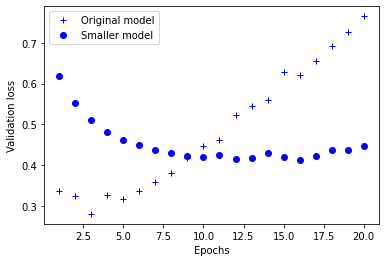

In [ ]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model') #original은 파란색 +로 되어있고,
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model') #smaller는 파랜색 o로 되어 있는 것을 볼 수 있다.
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()
#그림에서 보면 original model이 처음에는 최적화 되었다가 점차 overfitting되어가는 것을 볼 수 있다.
#그리고 smaller는 조금사용해서 과적합이 조금더 천천히 일어나는 것을 볼 수 있다.


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

# 사이즈를 크게 한 경우

In [ ]:
#smaller로 줄이게 되면 위에 보이는 그림 처럼 과적합이 천천히 되는 것을 볼 수 있었는데, 우리는 여기에서 bigger로 하게되면 어떠하게 되는지에 대해 보게된다. 
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))  #여기에서는 512개를 달아가지고 
bigger_model.add(layers.Dense(512, activation='relu')) #여기도 512를 달아주고 
bigger_model.add(layers.Dense(1, activation='sigmoid')) #마지막에는 1을 달아준다. 그리고 모형을 만들어 준다.

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [ ]:
#여기에서는 교수님이 bigger model에 대한 summary를 보셨다.
bigger_model.summary()

#코드를 돌려본 결과 Trainable params가 5,383,681개의 parameter를 수행하는 것을 볼 수 있다.
#즉, 크기를 크게 한 결과 Trainable params의 숫자도 커진것을 확인 할 수 있습니다.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#여기에서는 bigger model로 train을 진행해준다.
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))
#그리고 parameter를 많이 사용하다보니깐 train acc가 점점 높아지는 것을 알 수 있다.
#그래서 너무 많은 parameter를 사용하다 보니 train acc가 1.0000으로 되서 과적합이 일어나는 것을 볼 수 있다.

Epoch 1/20
49/49 [==============================] - 17s 336ms/step - loss: 0.6075 - acc: 0.7051 - val_loss: 0.2863 - val_acc: 0.8830
Epoch 2/20
49/49 [==============================] - 16s 321ms/step - loss: 0.2272 - acc: 0.9101 - val_loss: 0.3402 - val_acc: 0.8654
Epoch 3/20
49/49 [==============================] - 16s 321ms/step - loss: 0.1250 - acc: 0.9569 - val_loss: 0.6596 - val_acc: 0.7865
Epoch 4/20
49/49 [==============================] - 16s 323ms/step - loss: 0.0745 - acc: 0.9758 - val_loss: 1.1603 - val_acc: 0.7501
Epoch 5/20
49/49 [==============================] - 16s 321ms/step - loss: 0.1262 - acc: 0.9658 - val_loss: 0.5559 - val_acc: 0.8332
Epoch 6/20
49/49 [==============================] - 16s 321ms/step - loss: 0.0116 - acc: 0.9995 - val_loss: 0.6637 - val_acc: 0.8804
Epoch 7/20
49/49 [==============================] - 16s 321ms/step - loss: 0.0247 - acc: 0.9971 - val_loss: 0.5634 - val_acc: 0.8758
Epoch 8/20
49/49 [==============================] - 16s 322ms/step - 

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

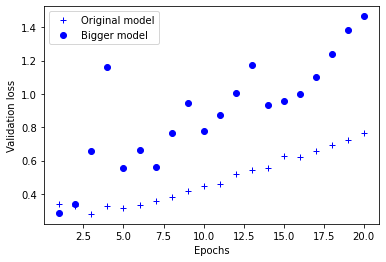

In [ ]:
#여기에서는 original과 bigger를 비교를 해서 그림을 그려준다.(original_val_loss와 bigger_model_val_loss를 사용함.)
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()
#그림에서 보았을 때, bigger model은 어느정도 해까지 근접했다가 되게 빠르게 안좋아지는 것을 볼 수 있다. 그래서 overfitting이 더 빠르게 일어나는 것을 알 수 있다.


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

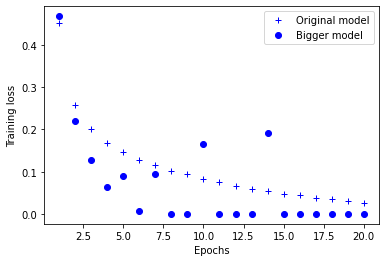

In [ ]:
#여기는 train loss에 대해서 보고 있으며, 그림에서 보았을 때 거의 0을 찍고 있다는 것을 볼 수 있다.
#그래서 bigger가 train set에 대해서 과적합이 심하게 일어났다는 것을 알 수 있다. 
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight 
regularization to our movie review classification network:

- You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions.

- simple model이 좋다는 것을 강조를 하고 있다. 

- A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). 

- parameter들이 entropy를 적게 갖는것이 simple한 model이라고 설명하고 있다.그리고 parameter들이 위로 팍 치고 나가는 것을 방지하기 위해서 regularization기법들을 적용해가지고, l1-regularization, l2-regularization을 설명하고 있는데, 여기에서 l1-regularization은 l1-norm(절대값)을 loss뒤에 추가해줘서 parameter들이 l1-norm기준으로 커지는 것을 막아주는 그러한 것이 되고, l2-regularization은  loss에 다가 parameter들에 대한 l2-norm을 regularization으로 줘서 parameter들의 값이 많이 커지지 않겠금 해주는 역할 이라고 할 수 있다.

- 그리고 케라스에서는 regularization을 쉽게 달 수 있다. 

In [ ]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), #original data에서는 앞에와 다똑같은데, kernel_regularizer=regularizers.l2(0.001)가 다르다.
                          activation='relu', input_shape=(10000,)))  #0.001이 숫자는 l2-regularization을 얼마나 심하게 할 건지를 조절해주는 parameter가 된다.
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',   #이 부분에서 컴파일을 해주고
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [ ]:
#l2-norm은 재미있는게 parameter의 숫자는 똑같다.
l2_model.summary()

#코드를 돌려보았을때, Trainable params는 160,305 그래서 parameter의 갯수 자체는 똑같은데, loss를 minimized할때, parameter가 튀지 않는 그 부분을 추가 해줌으로써
#더 simple한 모델이 나올 수 있겠금 해준다. 그런 부분이 되겠다.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2 regularization penalty:

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train, 
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))
#이 코들를 돌리게 되면 train acc가 막 올라가지 않는것을 볼 수 있는데, 이게 overfitting이 안된다는 증거이다.
#train loss가 막 치고 올라가는 것을 너무 좋은게 아니라 그건 overfitting이 되고 있다라고 판단해도 좋다.
#그래서 이렇게 덜 올라가는게 더 좋을 수 도 있다.

Epoch 1/20
49/49 [==============================] - 3s 60ms/step - loss: 0.5821 - acc: 0.7431 - val_loss: 0.3723 - val_acc: 0.8850
Epoch 2/20
49/49 [==============================] - 2s 38ms/step - loss: 0.3196 - acc: 0.9102 - val_loss: 0.3331 - val_acc: 0.8897
Epoch 3/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2674 - acc: 0.9243 - val_loss: 0.3585 - val_acc: 0.8731
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2417 - acc: 0.9338 - val_loss: 0.3444 - val_acc: 0.8806
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2251 - acc: 0.9410 - val_loss: 0.3425 - val_acc: 0.8837
Epoch 6/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2222 - acc: 0.9394 - val_loss: 0.3512 - val_acc: 0.8808
Epoch 7/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2105 - acc: 0.9461 - val_loss: 0.4245 - val_acc: 0.8562
Epoch 8/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2092 - a

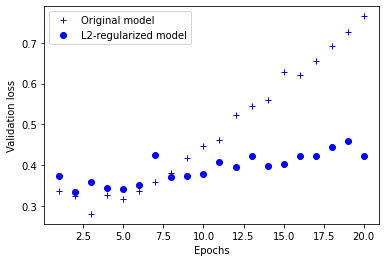

In [ ]:
#여기에서는 original_val_loss과 l2_model_val_loss를 비교해서 그림을 그려보았다.
l2_model_val_loss = l2_model_hist.history['val_loss']  

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()
#original_model이것은 처음에는 내려가다가 계속해서 overfitting해서 올라가는 반면에, 
#l2_model_model이것은 overfitting 되는 것을 잘 막아주고 있다는 것을 볼 수 있다.

#그런데 그림에서 보이는 것 처럼 original model이 Epochs가 2.5부분에서는 l2_model보다 Validation loss가 낮기 때문에 더 좋다는것을 알 수 있다.
#그래서 교수님이 말씀하시길 original mode의 Epochs를 2.5부분 쯤에서 짤라서 사용하는 것도 좋다고 말씀하심.
#그래서 nurel network에서는 l1과 l2말고도 dropot을 사용한다고 말씀하심.



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), 
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [ ]:
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)  #위에서는 l2를 달아 주었지만, 여기에서 처럼 l1으로 해서 코드를 달아 줄 수 있다.

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)  #그리고 여기에서 처럼 l1과 l2를 같이 사용해서도 사용할 수 있다.

In [ ]:
#이거는 L1 regularization을 사용한 방법이다.
from tensorflow.keras import regularizers

l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), 
                          activation='relu', input_shape=(10000,)))  
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))
#그리고 L1과 L2를 같이 사용하기 위해서는 regularizers.l1_l2(l1=0.001, l2=0.001)이렇게 바꾸어 주면 된다.

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be 
zero-ing out at random a fraction of the values in the matrix:

- dropout에 대한 예제를 진행해 본다.

-  Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

- Drpout은 neural networks 쪽에서 가장 효율적이고 가장 많이 사용하는 regularization 방법이고, 성능면에서는 l1, l2보다 dropout이 더 좋다는 것을 알 수 있다. 

- Dropout의 아이디어는 layer에서 random하게 droping out해가지고 일부 node들을 0으로 만들고 나머지들은 그대로 두는 방법으로 해두게된다.

-그래서 왜 이렇게 하면 성능이 좋아지냐? node전체를 사용해서 해 나아가다 보면,일부 node에 쏠리게 되는 현상이 발생하게 된다.그래서 node들이 전부 트레이닝 하게 되면 일부 node들이 쏠리는 현상이 발생하게 되는데, [0, 0.5, 1.3, 0, 1.1]이런식으로 일부 node들을 drop하게 되면 그런 쏠림현상이 많이 줄어들게 되고, 그리고 쏠림현상이 줄어들게 되면 다른쪽으로도 길을 많이 터주기 때문에 그래서 전체적으로보았을 때 일부 node에 쏠리는 현상을 막아 줄 수 있다. 그래서 reguralization되는 효과도 있다.

- 그리고 dropout이 randomforest와 비슷하게 앙상블을 사용해서 합쳐줘서 사용하는 것 같은 효과가 있다는 점에서 비슷하다고 볼 수 있다.

In [ ]:
import numpy as np 
np.random.randint(0, high=2, size=20)
#대충 50%의 점들을 0으로 만들거나 1로 만들어주고 
#여기에 layer_output을 곱해주게 되면 1이 있는 부분은 살아남게 되고, 0이 있는 부분은 0으로 되는 것을 알 수 있다. 

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)   #이거는 이런 느낌으로 구현된다고 생각할 수 있는 예제이다. 
#이거는 layer_output에 np.randint(0, high=2, size=layer_output.shape)이거를 곱해준다는 것인데 

NameError: ignored


At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the 
units):

In [ ]:
# At test time:
layer_output *= 0.5
#락다운 안된 전체 애들이 살아 있어서 그래서 전체가 살아 있어서 가중치를 0.5를 곱해서 testing time에서 해주겠다는 것이다. 
#그리고 여기에서는 위에 0.5를 해주었기 때문에 test time에 0.5를 곱해준다.


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is 
often the way it is implemented in practice:

In [ ]:
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5  #위에 있는 코드를 똑같이 해주려면 train time에서 layer_output을 0.5로 나누어주면 test time에서 따로 layer_output *= 0.5해주지 않아도 된다.
#그래서 실제로 dropout의 구현은 이런느낌으로 되어 있다라는 것을 볼 수 있다. 


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
model.add(layers.Dropout(0.5))

NameError: ignored

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))   #케라스에서는 간단하게 0.5를 dropout해주면 되겠다라고 하는 것이다. 
#Dense layers 16에다가 Dropout을 0.5적용한 것이고
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
#Dense layers 16에다가 Dropout을 0.5적용한 것이고
dpt_model.add(layers.Dense(1, activation='sigmoid'))   #그래서 두 층에 dropout layers를 추가한것을 볼 수 있다.

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [ ]:
#dropout을 하게 되더라도 모델의 개수에는 변함이 없다.
dpt_model.summary()
#그래서 Trainable params는 160.305가 되는 것을 볼 수 있다. 그리고 아래 보이는 것 처럼 dropout layer만 추가 된 것을 볼 수 있다.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#dropout이 된 것을 train해주게 되면 
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))
#original model보다는 acc가 더 빠르게 올라기지 않는 것을 볼 수 있다. 

Epoch 1/20
49/49 [==============================] - 6s 102ms/step - loss: 0.6364 - acc: 0.6197 - val_loss: 0.4408 - val_acc: 0.8667
Epoch 2/20
49/49 [==============================] - 3s 69ms/step - loss: 0.4567 - acc: 0.8101 - val_loss: 0.3370 - val_acc: 0.8836
Epoch 3/20
49/49 [==============================] - 2s 39ms/step - loss: 0.3693 - acc: 0.8658 - val_loss: 0.2991 - val_acc: 0.8875
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.3089 - acc: 0.8969 - val_loss: 0.2844 - val_acc: 0.8886
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2574 - acc: 0.9159 - val_loss: 0.2902 - val_acc: 0.8793
Epoch 6/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2289 - acc: 0.9282 - val_loss: 0.2962 - val_acc: 0.8880
Epoch 7/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2025 - acc: 0.9392 - val_loss: 0.3140 - val_acc: 0.8819
Epoch 8/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1754 - 

Let's plot the results:

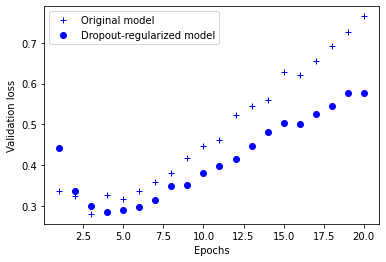

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()
#위에서 acc가 빠르게 올라가지 않는것은 여기에서 original_val_loss와 dpt_model_val_loss를 보았을 때 알 수 있다. 
#dropout도 물론 overfitting이 일어나지만 original보다 천천히 일어난다는 것을 알 수 있다. 
#그리고 그림에서 보았을때, l1과 l2보다 Epochs 2.5에서 5.0사이가 dropout했을 때 좀더 좋아 진것을 볼 수 있다. 즉 Validation loss가 더 좋아졌다.
#이래서 l1과 l2보다 dropout을 많이 사용을 한다. 그 이유가 성능면에서도 더 좋아지는 경우가 많아서 overfitting을 방지해주면서도 높은 성능을 유지해주는 그런 기법이여서
#neural network에서는 많이 사용하고 있다. 


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.